# Tutorial Dynap-SE 1 - Introduction

In [1]:
# Groningen, The Netherlands
# Author: Fernando M. Quintana

# Adapted from 2022 MemrisTec Summer School Dynapse1 tutorial and Samna 0.17 Demo from dynap-se1 library (https://code.ini.uzh.ch/ncs/libs/dynap-se1/-/blob/main/Samna_demo.ipynb)

In [2]:
import samna
import samna.dynapse1 as dyn1
import sys
sys.path.append("./dynap-se1/")

from dynapse1constants import *

import dynapse1utils as ut
import netgen as n
from netgen import Neuron
from params import gen_clean_param_group
from dynapse1constants import NEURONS_PER_CORE, ISI_NUM_BITS, ADDR_NUM_BITS
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_theme()

In [4]:
model, gui_thread = ut.open_dynapse1(gui=False)

[0]:  Bus 1 Device 10 Dynapse1DevKit serial_number 00000028
0 Dynapse1Wrapper created! libcaer init...
Clearing chip 0... DONE.
Clearing chip 1... DONE.
Clearing chip 2... DONE.
Clearing chip 3... DONE.
Selected device: 00000028
Sender port: tcp://0.0.0.0:50787
Receiver port: tcp://0.0.0.0:52071
Opened device name: Dynapse1DevKit
SamnaNode ID: 1
PythonNode ID: 2


In [5]:
paramGroup = gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

In [6]:
from live_gui.sliderGui import run_threaded_gui

run_threaded_gui(model)

/home/p306945/Projects/memristec/./dynap-se1/live_gui/linear_fine_coarse_bias_map.npy


## Board configuration

In [7]:
config = model.get_configuration()

chip_id = 3
core_id = 2
neuron_id = 10
print("Linear: " + str(config.chips[chip_id].cores[core_id].parameter_group.get_linear_parameter('IF_TAU1_N')))
print("Coarse: " + str(config.chips[chip_id].cores[core_id].parameter_group.param_map['IF_TAU1_N'].coarse_value))
print("Fine: " + str(config.chips[chip_id].cores[core_id].parameter_group.param_map['IF_TAU1_N'].fine_value))

Linear: 1568628.0
Coarse: 4
Fine: 80


The full list of biases available:

* IF_AHTAU_N - Neuron’s firing threshold adaptation time constant
* IF_AHTHR_N - Neuron’s firing threshold max valueIF_AHW_P - Neuron’s firing threshold adaptation weight (how much the threshold rises with each spike)
* IF_BUF_P - N\A
* IF_CASC_N - Enables firing threshold adaptation
* IF_DC_P - DC current injected into a neuron
* IF_NMDA_N - Enable NMDA gating
* IF_RFR_N - Neuron refractory period
* IF_TAU1_N - Main neuron time constant (unless switched to TAU2)
* IF_TAU2_N - Secondary time constant (for every neuron either TAU1 or TAU2 can be selected)
* IF_THR_N - Neuron V_mem gain (not the firing threshold!)
* NPDPIE_TAU_F_P - Fast excitatory (AMPA) synapses time constant
* NPDPIE_TAU_S_P - Slow excitatory (NMDA) synapses time constant
* NPDPIE_THR_F_P - Fast excitatory (AMPA) synapses threshold (i.e. max I_syn value)
* NPDPIE_THR_S_P - Slow excitatory (NMDA) synapses threshold (i.e. max I_syn value)
* NPDPII_TAU_F_P - Fast inhibitory (GABA_A) synapses time constant
* NPDPII_TAU_S_P - Slow inhibitory (GABA_B) synapses time constant
* NPDPII_THR_F_P - Fast inhibitory (GABA_A) synapses threshold (i.e. max I_syn value)
* NPDPII_THR_S_P - Slow inhibitory (GABA_B) synapses threshold (i.e. max I_syn value)
* PS_WEIGHT_EXC_F_N - Fast excitatory (AMPA) synapse weights
* PS_WEIGHT_EXC_S_N - Slow excitatory (NMDA) synapse weights
* PS_WEIGHT_INH_F_N - Fast inhibitory (GABA_A) synapse weights
* PS_WEIGHT_INH_S_N - Slow inhibitory (GABA_B) synapse weights
* PULSE_PWLK_P - Pulse width for synapses
* R2R_P - N\A

## Excercise 1: Monitor single neuron

In [8]:
api  =  model.get_dynapse1_api()
api.monitor_neuron(chip_id, ut.get_global_id(0, core_id, neuron_id))

## Exercise 2: Inject DC input current to selected core

In [9]:
param = dyn1.Dynapse1Parameter("IF_DC_P", 3, 4)
model.update_single_parameter(param, chip_id, core_id)

In [10]:
# Long ref. period
param = dyn1.Dynapse1Parameter("IF_RFR_N", 3, 4)
model.update_single_parameter(param, chip_id, core_id)

In [11]:
# Short ref. period
param = dyn1.Dynapse1Parameter("IF_RFR_N", 4, 128)
model.update_single_parameter(param, chip_id, core_id)

## Exercise 3: Event Graph, retreiving spikes from the board

In [12]:
neuron_ids = np.array([[chip_id, core_id, n_id] for n_id in np.arange(0,100)])

In [13]:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron_ids)
graph.start()

# clear the output buffer
sink_node.get_events()
# sleep for 1 second
time.sleep(1)

# We can edit the filter node on the fly
filter_node.set_neurons([[chip_id, (core_id+1)%4, n_id] for n_id in np.arange(0,100)])
time.sleep(1)

filter_node.set_neurons([[chip_id, (core_id+2)%4, n_id] for n_id in np.arange(0,100)])
time.sleep(1)

filter_node.set_neurons([[chip_id, (core_id+3)%4, n_id] for n_id in np.arange(0,100)])
time.sleep(1)

# get the events accumulated during the past 1 sec
events = sink_node.get_events()
graph.stop()

print(f"Captured {len(events)} events")

Captured 583 events


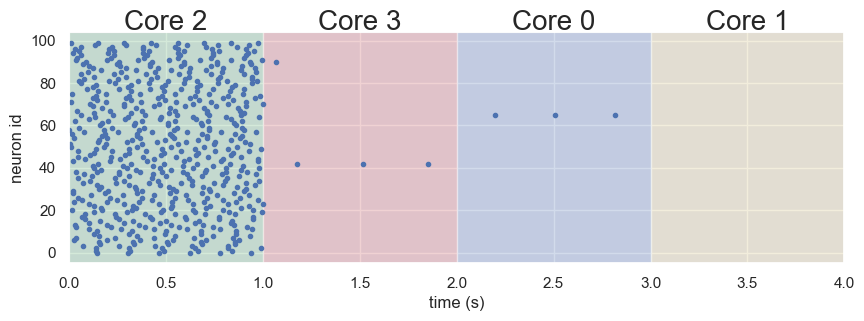

In [14]:
import matplotlib.dates as mdates

evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
time_n = (evts_n[:,0]-evts_n[0,0])*1e-6

fig, ax = plt.subplots(figsize=(10,3))
ax.axvspan(0, 1, facecolor='g', alpha=0.25)
ax.axvspan(1, 2, facecolor='r', alpha=0.25)
ax.axvspan(2, 3, facecolor='b', alpha=0.25)
ax.axvspan(3, 4, facecolor='y', alpha=0.25)

# ax.text(0.15, 1, r'$\sum_{i=0}^\infty x_i$', transform=ax.transAxes, va='top', ha='center', fontsize=20)
ax.annotate(f'Core {core_id}', (0.125, 1.01), ha='center', xycoords='axes fraction', fontsize=20)
ax.annotate(f'Core {(core_id+1)%4}', (0.375, 1.01), ha='center', xycoords='axes fraction', fontsize=20)
ax.annotate(f'Core {(core_id+2)%4}', (0.625, 1.01), ha='center', xycoords='axes fraction', fontsize=20)
ax.annotate(f'Core {(core_id+3)%4}', (0.875, 1.01), ha='center', xycoords='axes fraction', fontsize=20)

ax.plot(time_n, evts_n[:,1], '.')
ax.set_xlabel("time (s)")
ax.set_ylabel("neuron id")
ax.margins(x=0)
plt.show()

## Exercise 3: F-I Curve single neuron

In [256]:
DC_values = [(0, 0), (0, 50), (0, 100), (0, 200), (1, 50), (1, 100), (1, 200), (2, 50), (2, 100), (2, 200), (3, 50), (3, 100)]

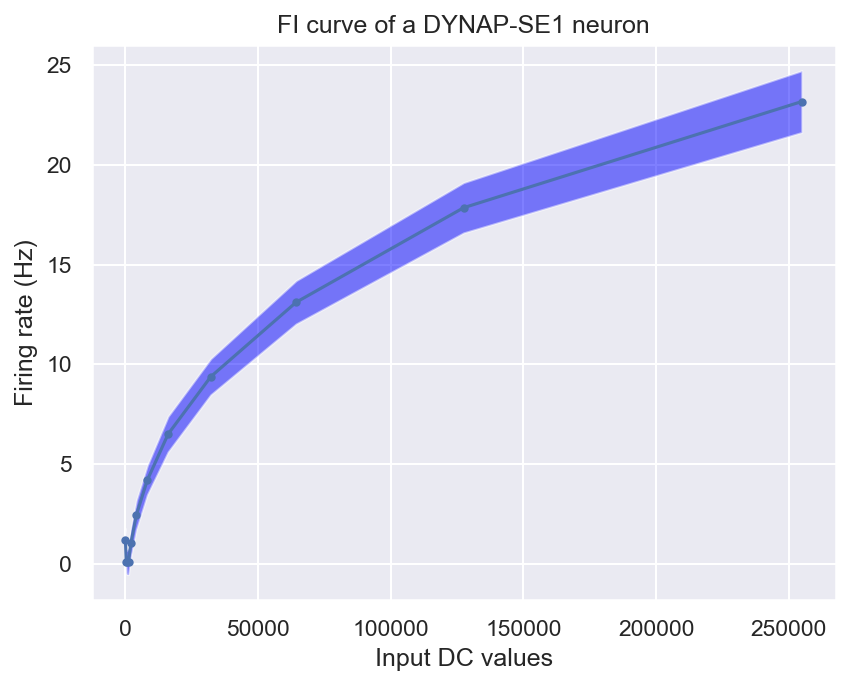

In [258]:
chip_id=1
core_id=0
neuron_ids = np.array([[chip_id, core_id, n_id] for n_id in np.arange(0,NEURONS_PER_CORE)])
linear_DC_values = []     # linear DC values, float instead of tuple
freqs = [] # result frequency list
std = []

for dc in DC_values:
    # Set new DC
    param = dyn1.Dynapse1Parameter("IF_DC_P", dc[0], dc[1])
    model.update_single_parameter(param, chip_id, core_id)

    # Get events:
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron_ids)
    graph.start()

    # clear the output buffer
    sink_node.get_events()
    # sleep for 1 second
    time.sleep(1)

    # get the events accumulated during the past 1 sec
    events = sink_node.get_events()
    graph.stop()

    evts_n = np.array([evt.neuron_id for evt in events])
    hist, bin_edges = np.histogram(evts_n, bins=NEURONS_PER_CORE, range=(0,NEURONS_PER_CORE))

    # Append the frequency to the list
    freqs.append(np.mean(hist))
    std.append(np.std(hist))

    # Append DC values:
    config = model.get_configuration()
    linear_dc_value = config.chips[chip_id].cores[core_id].parameter_group.get_linear_parameter("IF_DC_P")
    linear_DC_values.append(linear_dc_value)
freqs = np.array(freqs)
std = np.array(std)

# Plot f-I curve
fig, axs = plt.subplots(1,1, dpi=150)
axs.plot(linear_DC_values, freqs, ".-")
axs.fill_between(linear_DC_values, freqs+std, freqs-std, facecolor='blue', alpha=0.5)
axs.set_title('FI curve of a DYNAP-SE1 neuron')
axs.set_xlabel('Input DC values')
axs.set_ylabel('Firing rate (Hz)')
plt.show()

In [259]:
param = dyn1.Dynapse1Parameter("IF_RFR_N", 3, 4)
model.update_single_parameter(param, chip_id, core_id)

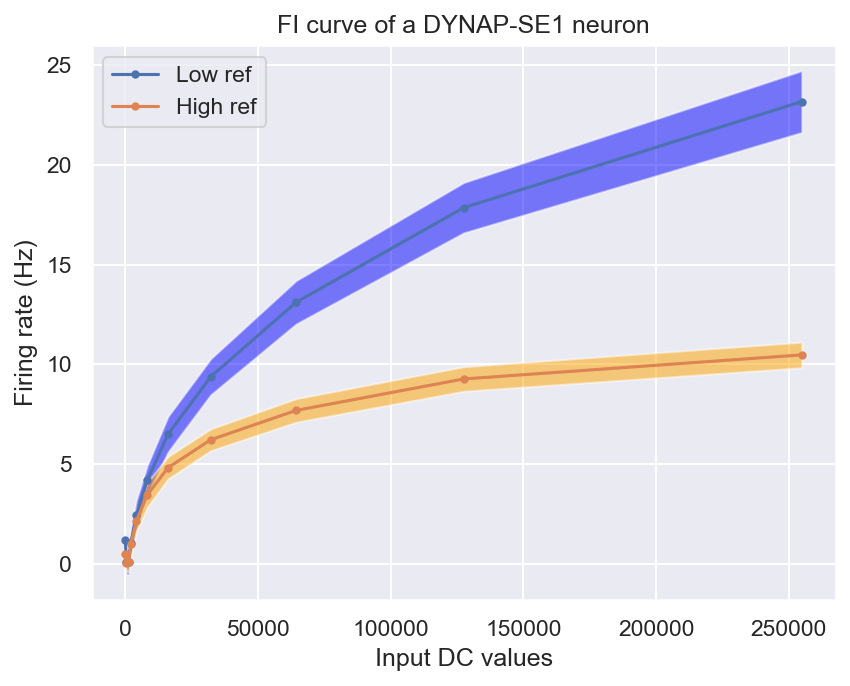

In [261]:
linear_DC_values_high_ref = []     # linear DC values, float instead of tuple
freqs_high_ref = [] # result frequency list
std_high_ref=[]

for dc in DC_values:
    # Set new DC
    param = dyn1.Dynapse1Parameter("IF_DC_P", dc[0], dc[1])
    model.update_single_parameter(param, chip_id, core_id)

    # Get events:
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron_ids)
    graph.start()

    # clear the output buffer
    sink_node.get_events()
    # sleep for 1 second
    time.sleep(1)

    # get the events accumulated during the past 1 sec
    events = sink_node.get_events()
    graph.stop()

    evts_n = np.array([evt.neuron_id for evt in events])
    hist, bin_edges = np.histogram(evts_n, bins=NEURONS_PER_CORE, range=(0,NEURONS_PER_CORE))

    # Append the frequency to the list
    freqs_high_ref.append(np.mean(hist))
    std_high_ref.append(np.std(hist))
freqs_high_ref = np.array(freqs_high_ref)
std_high_ref = np.array(std_high_ref)

# Plot f-I curve
fig, axs = plt.subplots(1,1, dpi=150)
plt.plot(linear_DC_values, freqs, ".-", label='Low ref')
axs.fill_between(linear_DC_values, freqs+std, freqs-std, facecolor='blue', alpha=0.5)

plt.plot(linear_DC_values, freqs_high_ref, ".-", label='High ref')
axs.fill_between(linear_DC_values, freqs_high_ref+std_high_ref, freqs_high_ref-std_high_ref, facecolor='orange', alpha=0.5)

axs.legend()
axs.set_title('FI curve of a DYNAP-SE1 neuron')
axs.set_xlabel('Input DC values')
axs.set_ylabel('Firing rate (Hz)')
plt.show()

## Exercise 4: Mismatch

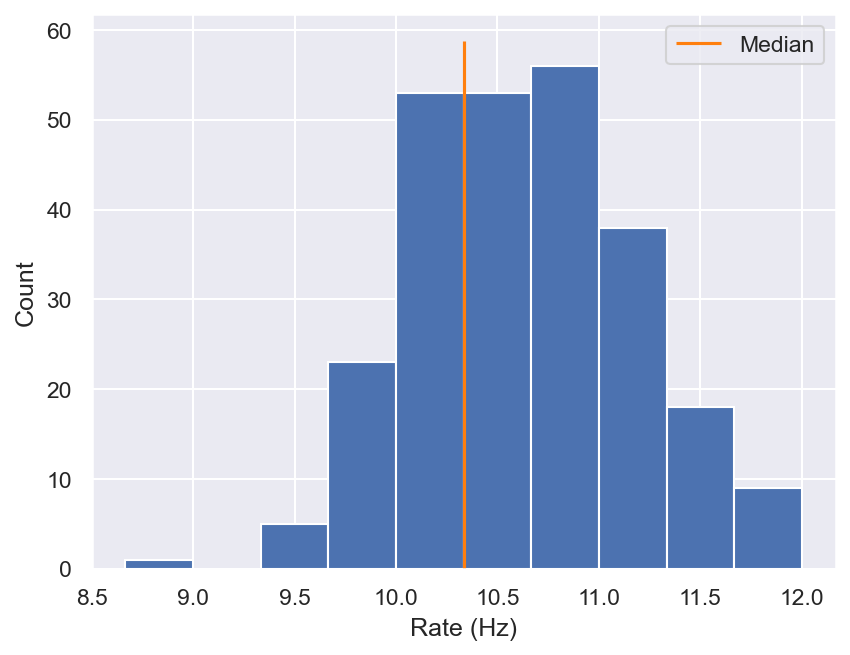

In [262]:
duration = 3 #seconds
# Get events:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, neuron_ids)
graph.start()

# clear the output buffer
sink_node.get_events()
# sleep for 1 second
time.sleep(duration)

# get the events accumulated during the past 1 sec
events = sink_node.get_events()
graph.stop()

count_nrns = np.zeros(NEURONS_PER_CORE)
for evt in events:
    count_nrns[evt.neuron_id] +=1
rate = count_nrns/duration

# Plot:
fig, axs = plt.subplots(1,1, dpi=150)
plt.hist(rate)
axs.set_xlabel('Rate (Hz)')
axs.set_ylabel('Count')
# Plot median:
plt.vlines(np.median(rate), axs.get_ylim()[0], axs.get_ylim()[1], label='Median', color='tab:orange')
axs.legend()

## Exercise 5: Observe the effec of synaptic inputs

In [738]:
from params import gen_param_group

paramGroup = gen_param_group()
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].coarse_value = 5
paramGroup.param_map["PS_WEIGHT_EXC_F_N"].fine_value = 180

paramGroup.param_map["PS_WEIGHT_INH_S_N"].coarse_value = 5
paramGroup.param_map["PS_WEIGHT_INH_S_N"].fine_value = 110
paramGroup.param_map["PS_WEIGHT_INH_F_N"].coarse_value = 5
paramGroup.param_map["PS_WEIGHT_INH_F_N"].fine_value = 110
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

### 5.1 Preparing the spike trains

In [739]:
spikegen_ids = [1, 2]
 #Maximum ISI. Can be avoided with dummy spikes
MAX_ISI = 2**ISI_NUM_BITS-1
print(str(MAX_ISI*1e-06 * 10) + " s")

0.65535 s


In [740]:
#Maximum spike train length
MAX_LEN = 2**ADDR_NUM_BITS-1
print(MAX_LEN)

32767


In [741]:
#Spike train of spikegen 1
timestamps1 = np.linspace(0,1,100)
indices1 = np.ones(len(timestamps1))*spikegen_ids[0]

timestamps2 = np.linspace(0,1,25)
indices2 = np.ones(len(timestamps2))*spikegen_ids[1]

spiketrain = np.concatenate((np.column_stack((timestamps1,indices1)), np.column_stack((timestamps2,indices2))))
spiketrain = spiketrain[spiketrain[:,0].argsort()]

Text(0, 0.5, 'spikegen')

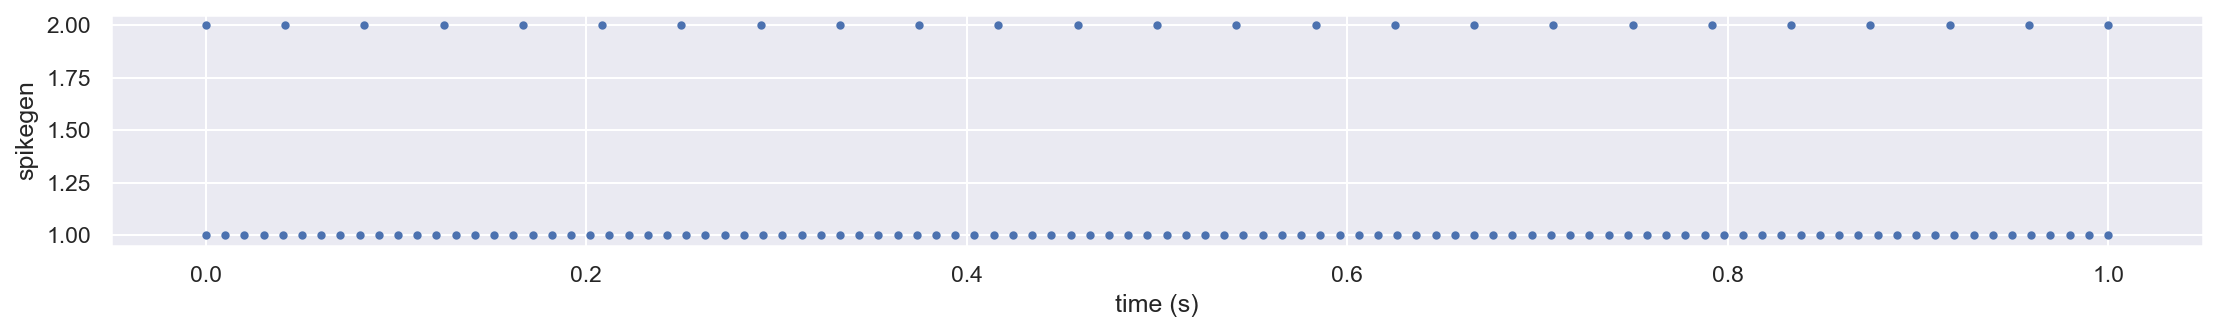

In [742]:
plt.figure(figsize=(18,2), dpi=150)
plt.plot(spiketrain[:,0], spiketrain[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("spikegen")

### 5.3 FPGA Spike generation

In [743]:
fpga_spike_gen = model.get_fpga_spike_gen()
ut.set_fpga_spike_gen(fpga_spike_gen, spike_times=spiketrain[:,0], indices=spiketrain[:,1].astype(int), target_chips=[chip_id]*len(spiketrain), isi_base=90, repeat_mode=True)

VariableIsiMode already 1
RepeatMode already 1


### 5.4 Connecting the Spike Generator

In [744]:
import netgen as n
from netgen import Neuron

In [745]:
spikegen_neuron1 = Neuron(0,0,1,is_spike_gen=True)
spikegen_neuron2 = Neuron(0,0,2,is_spike_gen=True)
neurons = [Neuron(chip_id,core_id,10), Neuron(chip_id,core_id,11)]

net_gen = n.NetworkGenerator()
net_gen.add_connection(spikegen_neuron1, neurons[0], dyn1.Dynapse1SynType.AMPA)
net_gen.add_connection(spikegen_neuron2, neurons[0], dyn1.Dynapse1SynType.GABA_B)
net_gen.add_connection(spikegen_neuron1, neurons[1], dyn1.Dynapse1SynType.AMPA)
print(net_gen.network)

Post neuron (ChipId,coreId,neuronId): incoming connections [(preNeuron,synapseType), ...]
C1c0n10: [('C0c0s1', 'AMPA'), ('C0c0s2', 'GABA_B')]
C1c0n11: [('C0c0s1', 'AMPA')]



In [746]:
 # make a dynapse1config using the network
config = net_gen.make_dynapse1_configuration()

# apply the configuration
model.apply_configuration(config)

New configuration applied to DYNAP-SE1!


In [747]:
fpga_spike_gen.start()

Spikes collected: 42


Text(0, 0.5, 'neuron id')

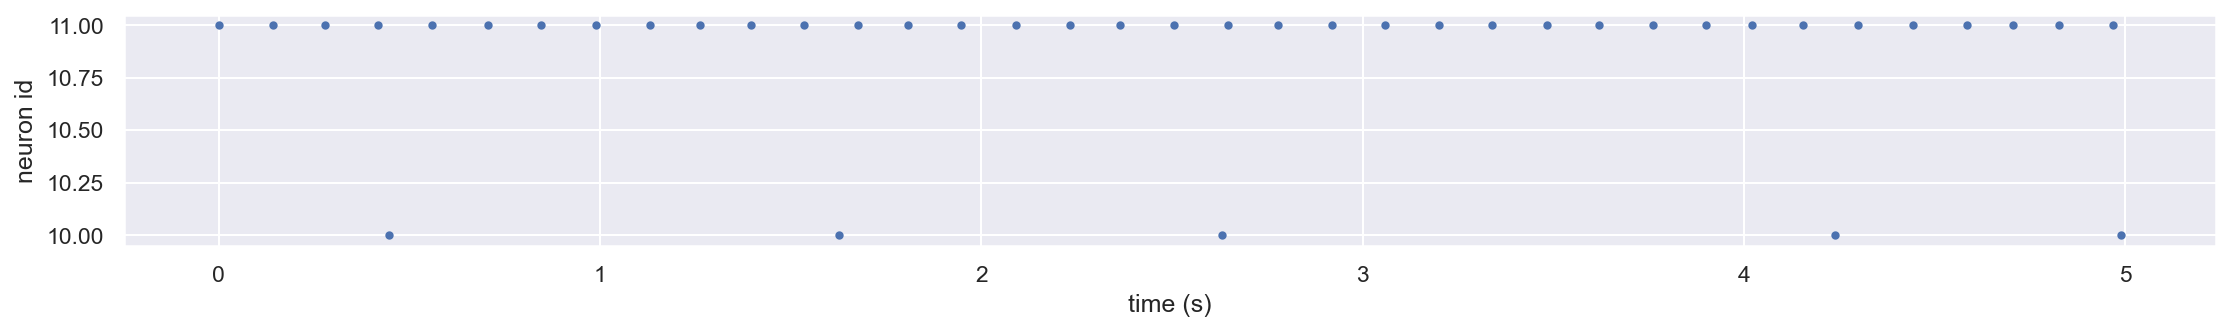

In [748]:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [[chip_id, core_id, 10], [chip_id, core_id, 11]])
graph.start()
sink_node.get_events()
time.sleep(5)
events = sink_node.get_events()
graph.stop()
print("Spikes collected:", len(events))

evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
time_n = (evts_n[:,0] - evts_n[0,0])*1e-6

plt.figure(figsize=(18,2), dpi=150)
plt.plot(time_n, evts_n[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("neuron id")

In [749]:
net_gen.remove_connection(spikegen_neuron2, neurons[0], dyn1.Dynapse1SynType.GABA_B)
config = net_gen.make_dynapse1_configuration()
model.apply_configuration(config)

New configuration applied to DYNAP-SE1!


Spikes collected: 70


Text(0, 0.5, 'neuron id')

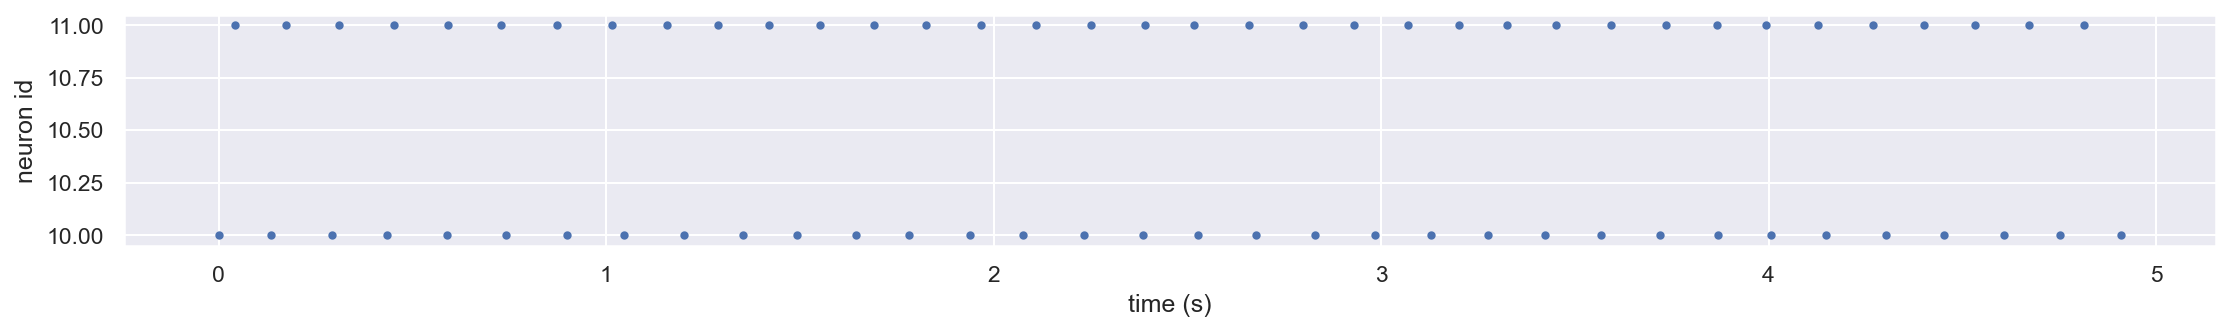

In [750]:
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [[chip_id, core_id, 10], [chip_id, core_id, 11]])
graph.start()
sink_node.get_events()
time.sleep(5)
events = sink_node.get_events()
graph.stop()
print("Spikes collected:", len(events))

evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
time_n = (evts_n[:,0] - evts_n[0,0])*1e-6

plt.figure(figsize=(18,2), dpi=150)
plt.plot(time_n, evts_n[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("neuron id")

In [751]:
fpga_spike_gen.stop()

## 5.5 Poisson generator

In [760]:
# set up Poisson spike generators:
rate = 50

poisson_gen = model.get_poisson_gen()

# set the target chip of the post neurons
poisson_gen.set_chip_id(chip_id)
poisson_gen.write_poisson_rate_hz(1, rate)

# check the configuration...
config = model.get_configuration()
model.apply_configuration(config)

New configuration applied to DYNAP-SE1!


In [761]:
poisson_gen.start()
graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [[chip_id, core_id, 10], [chip_id, core_id, 11]])
graph.start()
sink_node.get_events()
time.sleep(5)
events = sink_node.get_events()
graph.stop()
poisson_gen.stop()
print("Spikes collected:", len(events))

Spikes collected: 39


Text(0, 0.5, 'neuron id')

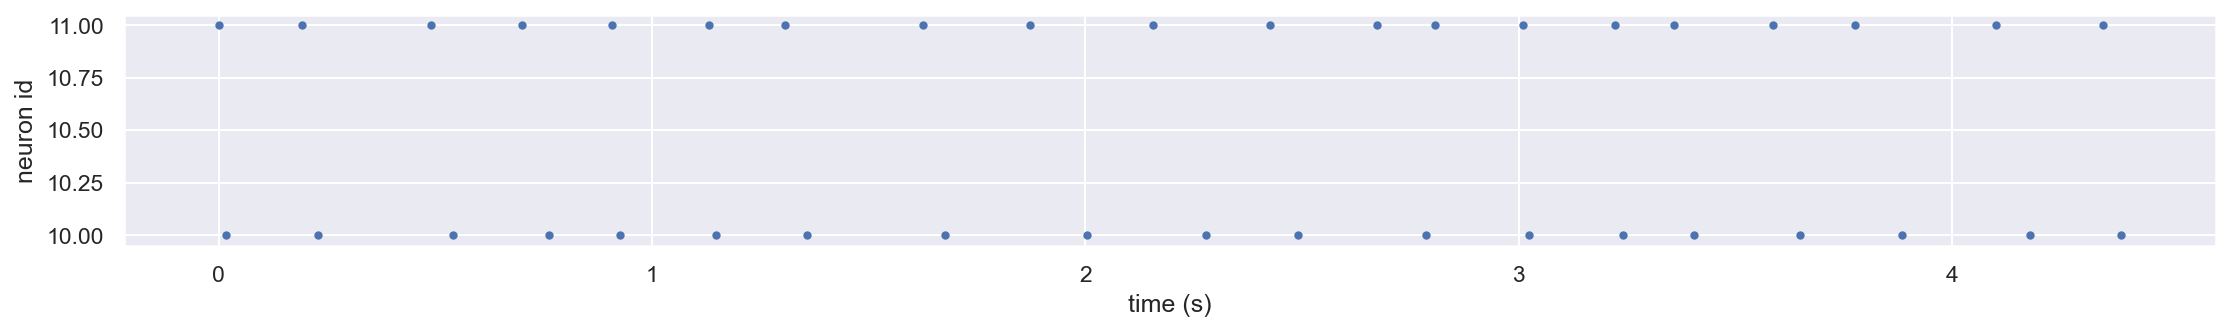

In [762]:
evts_n = np.array([[evt.timestamp, evt.neuron_id] for evt in events])
time_n = (evts_n[:,0] - evts_n[0,0])*1e-6

plt.figure(figsize=(18,2), dpi=150)
plt.plot(time_n, evts_n[:,1], '.')
plt.xlabel("time (s)")
plt.ylabel("neuron id")

## 5.6 Effect of the DPI synaptic weight

In [765]:
paramGroup = gen_clean_param_group()
for chip in range(4):
    for core in range(4):
        model.update_parameter_group(paramGroup, chip, core)

# set up Poisson spike generators:
rate = 50

poisson_gen = model.get_poisson_gen()

# set the target chip of the post neurons
poisson_gen.set_chip_id(chip_id)
poisson_gen.write_poisson_rate_hz(1, rate)

# check the configuration...
config = model.get_configuration()
model.apply_configuration(config)
poisson_gen.start()

New configuration applied to DYNAP-SE1!


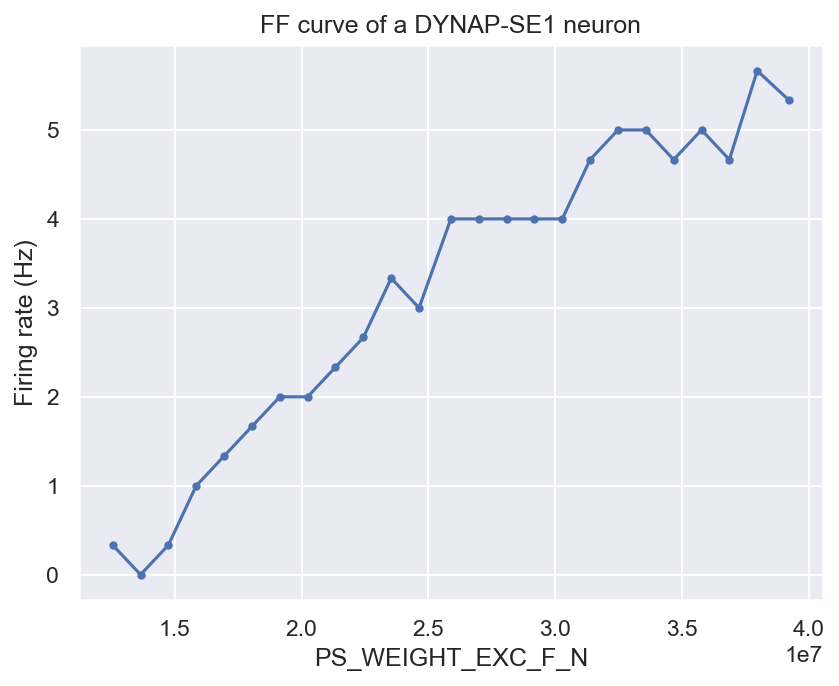

In [767]:
linear_w_value = []     # linear DC values, float instead of tuple
freqs = [] # result frequency list
bias = 'PS_WEIGHT_EXC_F_N'
w_values = [(5, fine) for fine in np.linspace(80,250,25, dtype=int)]
# neuron_ids = np.array([[chip_id, core_id, n_id] for n_id in np.arange(0,NEURONS_PER_CORE)])
for w in w_values:
    # Set new weight
    param = dyn1.Dynapse1Parameter(bias, w[0], w[1])
    model.update_single_parameter(param, chip_id, core_id)

    # Get events:
    graph, filter_node, sink_node = ut.create_neuron_select_graph(model, [[chip_id, core_id, 10]])
    graph.start()
    sink_node.get_events()
    time.sleep(3)
    events = sink_node.get_events()
    graph.stop()

    # Append the frequency to the list
    freq = len(events)/3
    freqs.append(freq)

    # Append DC values:
    config = model.get_configuration()
    linear_value = config.chips[chip_id].cores[core_id].parameter_group.get_linear_parameter(bias)
    linear_w_value.append(linear_value)

# Plot f-I curve
fig, axs = plt.subplots(1,1, dpi=150)
axs.plot(linear_w_value, freqs, ".-")
axs.set_title('FF curve of a DYNAP-SE1 neuron')
axs.set_xlabel('PS_WEIGHT_EXC_F_N')
axs.set_ylabel('Firing rate (Hz)')
plt.show()

In [768]:
poisson_gen.stop()

In [3]:
ut.close_dynapse1(model)